In [1]:
suppressMessages({
    library(udunits2)
    library(RNetCDF)
    library(dplyr)
    library(ggplot2)
    library(mapview)
    library(sf)
    library(leaflet)
    library(sfheaders)
    library(parallel)
    library(terra)
    library(forcats)
    library(tidyr)
    })

In [4]:
#read thedataframe----------
SES_df=readRDS('/nas/cee-water/cjgleason/colin/SWOT_global_Q_paper/SES_dataframe.rds')%>%
    st_as_sf()


[1] "model"    "reach_id" "SES"      "geometry"

Warning message:
“Width not defined
ℹ Set with `position_dodge(width = ...)`”


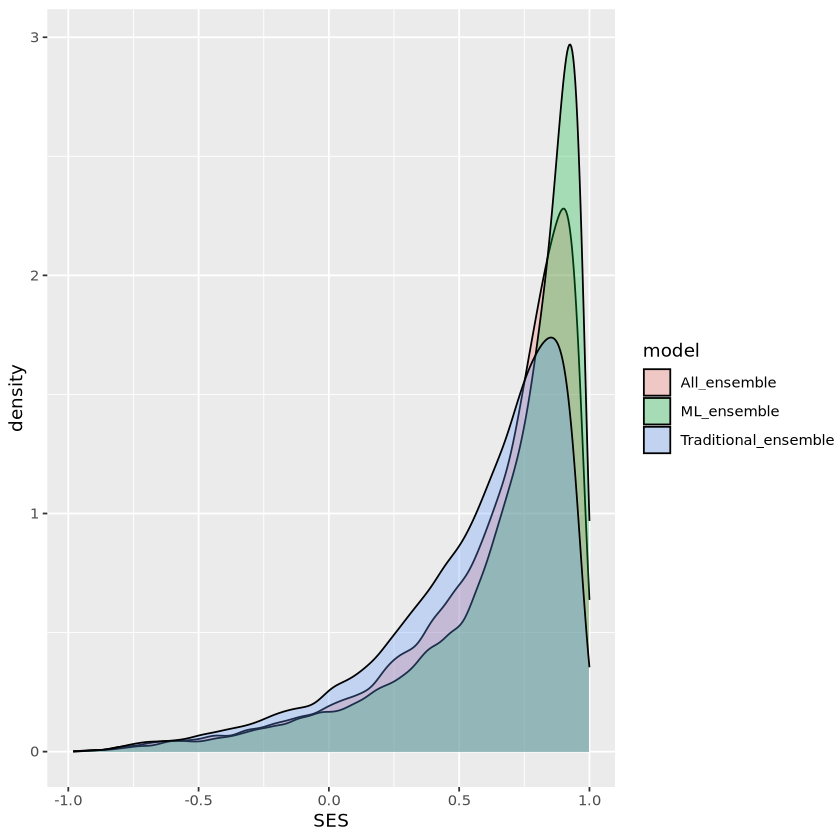

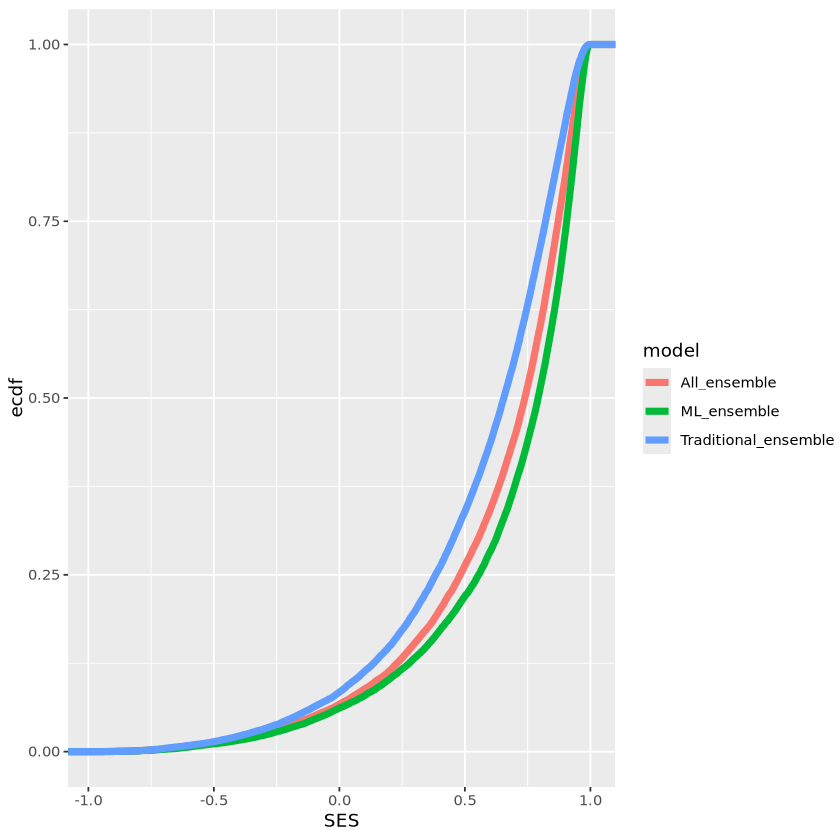

In [6]:
ggplot(SES_df)+
    geom_density(aes(x=SES,fill=model),position='dodge',alpha=0.3)

ggplot(SES_df)+
    stat_ecdf(aes(x=SES,colour=model),lwd=2)

In [7]:
wide_SES=pivot_wider(SES_df,names_from=model,values_from=SES)%>%
    mutate(ML_Trad_diff=ML_ensemble-Traditional_ensemble)


Attaching package: ‘tidyr’


The following object is masked from ‘package:terra’:

    extract




[1] "reach_id"             "geometry"             "ML_ensemble"         
[4] "All_ensemble"         "Traditional_ensemble" "ML_Trad_diff"

Warning message:
“A numeric `legend.position` argument in `theme()` was deprecated in ggplot2
3.5.0.
ℹ Please use the `legend.position.inside` argument of `theme()` instead.”


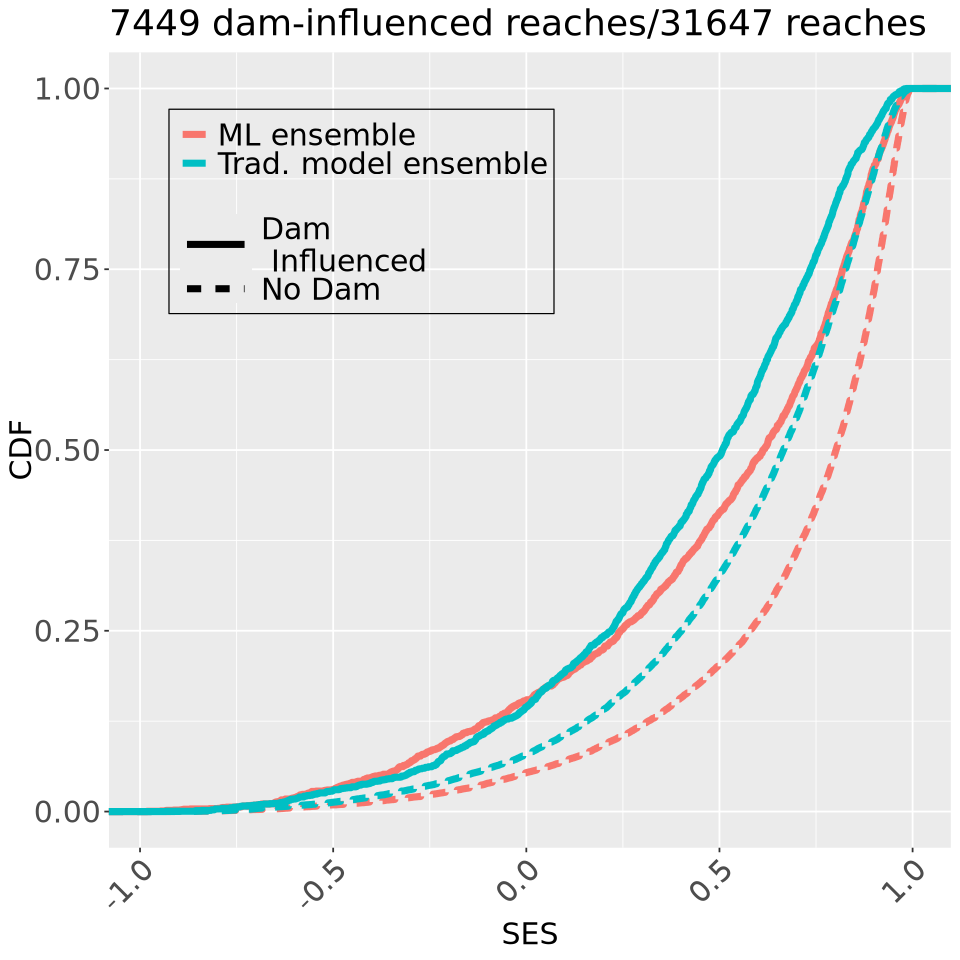

In [8]:
#investigate stats on dams
damlist=read.csv('/nas/cee-water/cjgleason/jonathan/tests/swot_hydropower/output/type1_dams_rev.csv')%>%
    mutate(has_dam=TRUE)
SES_dam=left_join(SES_df,damlist,by='reach_id')%>%
    filter(!is.na(SES))


num_reaches=length(unique(SES_df$reach_id))
num_dams=sum(!is.na(SES_dam$has_dam))

plotter1=select(SES_dam,has_dam,SES,model)%>%
    filter(!is.na(SES))%>%
    group_by(has_dam)%>%
    mutate(has_dam=ifelse(is.na(has_dam),'No Dam','Dam\n Influenced'))%>%
    mutate(nreaches=n())%>%
    filter(model!='All_ensemble')

annotator=plotter1%>%
            select(has_dam,nreaches)%>%
            distinct()

plotter1$model[plotter1$model=='ML_ensemble']='ML ensemble'
plotter1$model[plotter1$model=='Traditional_ensemble']='Trad. model ensemble'

p2=ggplot(plotter1)+

    stat_ecdf(aes(x=SES,col=model,linetype=has_dam),lwd=2)+
    theme(axis.text.x = element_text(size=18,angle = 45, hjust = 1))+
theme(axis.text.y = element_text(size=18))+
    theme(legend.title = element_blank())+
    theme(text = element_text(size=18))+
    theme(legend.text=element_text(size=18))+
    ylab('CDF')+
    xlab('SES')+
guides(linetype=guide_legend(keywidth = 3, keyheight = 1))+
         theme(legend.box.margin = margin(1, 20, 1, 1))+

theme(legend.position = c(0.3, 0.8),
    legend.background = element_rect(fill='transparent'),
         legend.box.background = element_rect(fill='transparent'))+
ggtitle(paste0(num_dams,' dam-influenced reaches/',num_reaches,' reaches'))

options(repr.plot.width=8, repr.plot.height=8)

p2

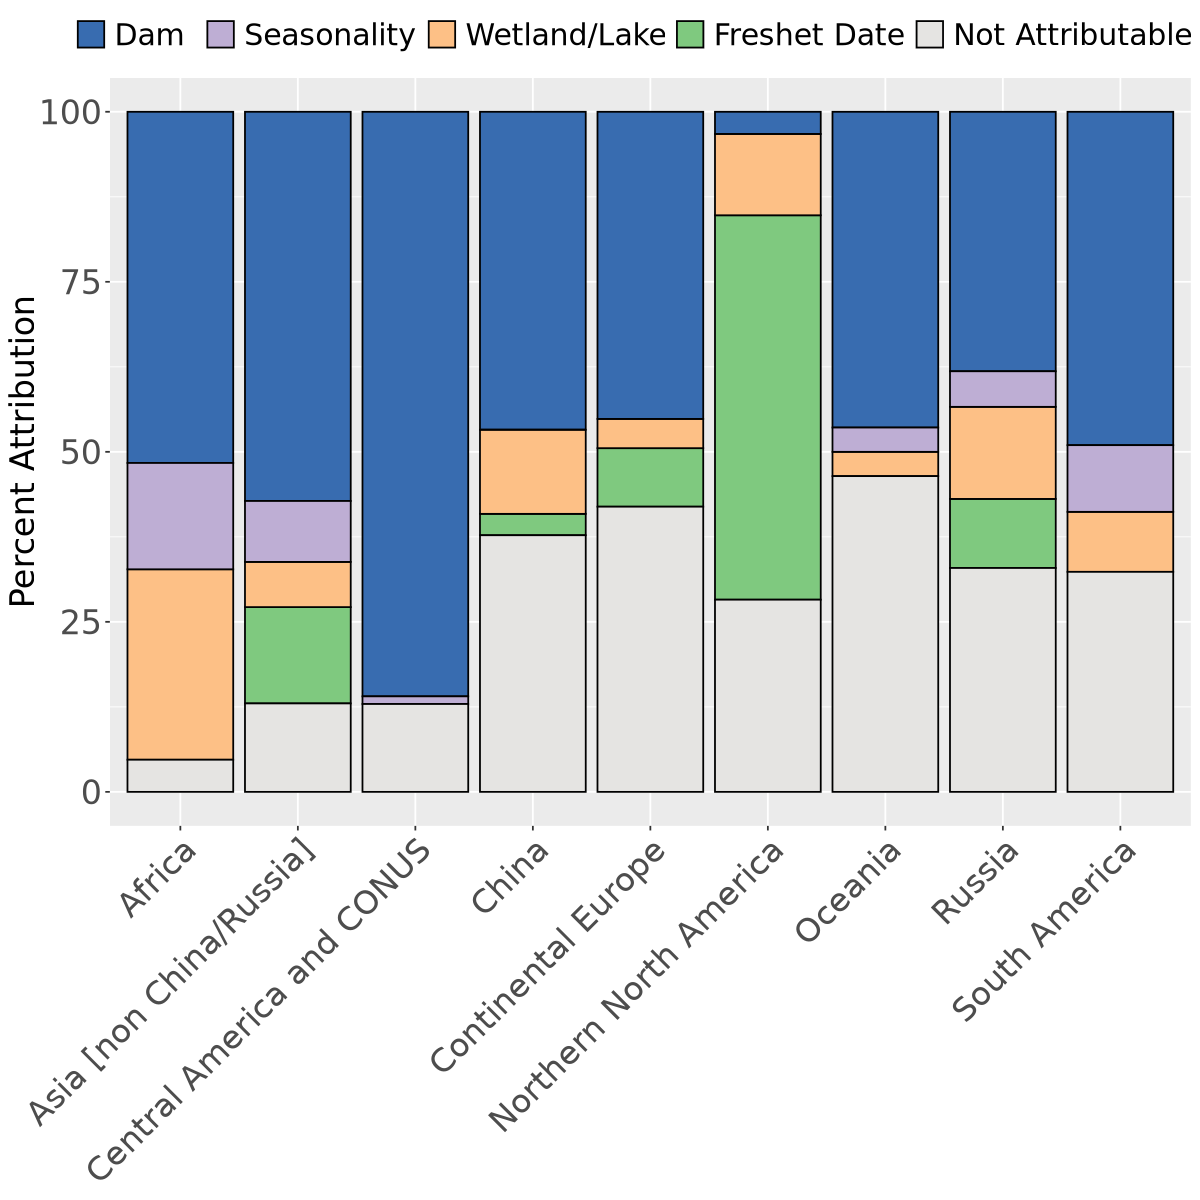

In [9]:
# generic boxplot block
# change the select statement to plot a different variable
library(dplyr)
library(tidyr)
library(ggplot2)

cases=read.csv('/nas/cee-water/cjgleason/colin/SWOT_global_Q_paper/attribution 2.csv')%>%
    transmute(Region=Continent,
              Dam=Dam,
              Freshet=Freshet,
              Wetland_Lake=Wetland.Lake,
              Seasonality=Seasonality,
              notAttributable=Not.attributable,
                        Total=Total)

cases[is.na(cases)]=0

totalvec=cases$Total

cases2=data.frame(apply(cases[,2:(ncol(cases)-1)],2,function(x){100*x/totalvec}))%>%
    mutate(Region=cases$Region)%>%
    mutate(Total=cases$Total)%>%
    select(-Total)

 plotter=gather(cases2,reason,Percent,-Region)

plotter$reason[plotter$reason=='Freshet']='Freshet Date'
plotter$reason[plotter$reason=='Wetland_Lake']='Wetland/Lake'
plotter$reason[plotter$reason=='notAttributable']='Not Attributable'
plotter$reason[plotter$reason=='Seasonality']='Seasonality'
plotter$reason[plotter$reason=='Dam']='Dam'
plotter=plotter%>%
  mutate(reason = fct_relevel(reason, 
            "Dam", "Seasonality", "Wetland/Lake",
            'Freshet Date','Not Attributable'))

rearranged_pallete=c('#386cb0',
'#beaed4',
'#fdc086',
'#7fc97f',
'#E5E4E2')

p1=ggplot(plotter)+
    geom_bar(aes(x=Region,y=Percent,fill=reason),color='black',stat='identity',position='stack')+


coord_cartesian(ylim=c(0,100))+


theme(axis.text.x=element_text(size=20,angle=45,hjust=1),
      axis.text.y=element_text(size=20),
      legend.box.margin = margin(1, 40, 1, 1),
      legend.text=element_text(size=18),
      axis.title.y=element_text(size=20),
      axis.title.x=element_text(size=15),
      legend.position='top',
      legend.title=element_blank(),
      legend.key.spacing.x = unit(0.6, 'cm'))+

   
ylab('Percent Attribution')+


 scale_fill_manual(values=rearranged_pallete)+
xlab('')

options(repr.plot.width=10, repr.plot.height=10)
p1

In [27]:

# Nile
# Nile_in=readRDS('/nas/cee-water/cjgleason/colin/SWOT_global_Q_paper/ML_trad_SES_dfs/17211900191_model_trad_SES.rds')%>%

#beas
# Nile_in=readRDS('/nas/cee-water/cjgleason/colin/SWOT_global_Q_paper/ML_trad_SES_dfs/45646000141_model_trad_SES.rds')%>%

#gods
Nile_in=readRDS('/nas/cee-water/cjgleason/colin/SWOT_global_Q_paper/ML_trad_SES_dfs/71327000061_model_trad_SES.rds')%>%
    select(date,model,smoothed_model,smoothed_swot)%>%
    filter(!is.na(smoothed_swot))

Nile2= Nile_in%>%
    filter(model == 'trad_ensemble') %>% 
    mutate(rescaled_model= (smoothed_model - min(smoothed_model))/(max(smoothed_model)-min(smoothed_model)) *
           (max(smoothed_swot) - min(smoothed_swot)) + min(smoothed_swot) )

Nile3= Nile_in%>%
    filter(model == 'ML_ensemble') %>% 
  mutate(rescaled_model= (smoothed_model - min(smoothed_model))/(max(smoothed_model)-min(smoothed_model)) *
           (max(smoothed_swot) - min(smoothed_swot)) + min(smoothed_swot) )

Nile_in=rbind(Nile2,Nile3)
           
Nile_in$model[Nile_in$model=='ML_ensemble']='ML ensemble'
Nile_in$model[Nile_in$model=='trad_ensemble']='Trad. model ensemble'


In [29]:

transfunc=function(dataframe){
    x=dataframe$smoothed_model
    newMax=max(dataframe$smoothed_swot)
     newMin=min(dataframe$smoothed_swot)
    (x - min(x))/(max(x)-min(x)) * (newMax - newMin) + newMin }


swot_df=select(ungroup(Nile_in), date, smoothed_swot)%>%
    mutate(model='SWOT')%>%
    transmute(date=date,height=smoothed_swot,model=model)

model_df=Nile_in%>%
    select(-smoothed_model,-smoothed_swot)%>%
     transmute(date=date,height=rescaled_model,model=model)

plotter=rbind(swot_df,model_df)


Warning message:
“Removed 20 rows containing missing values or values outside the scale range
(`geom_point()`).”
Warning message:
“Removed 20 rows containing missing values or values outside the scale range
(`geom_line()`).”
Warning message:
“Removed 20 rows containing missing values or values outside the scale range
(`geom_point()`).”
Warning message:
“Removed 20 rows containing missing values or values outside the scale range
(`geom_line()`).”


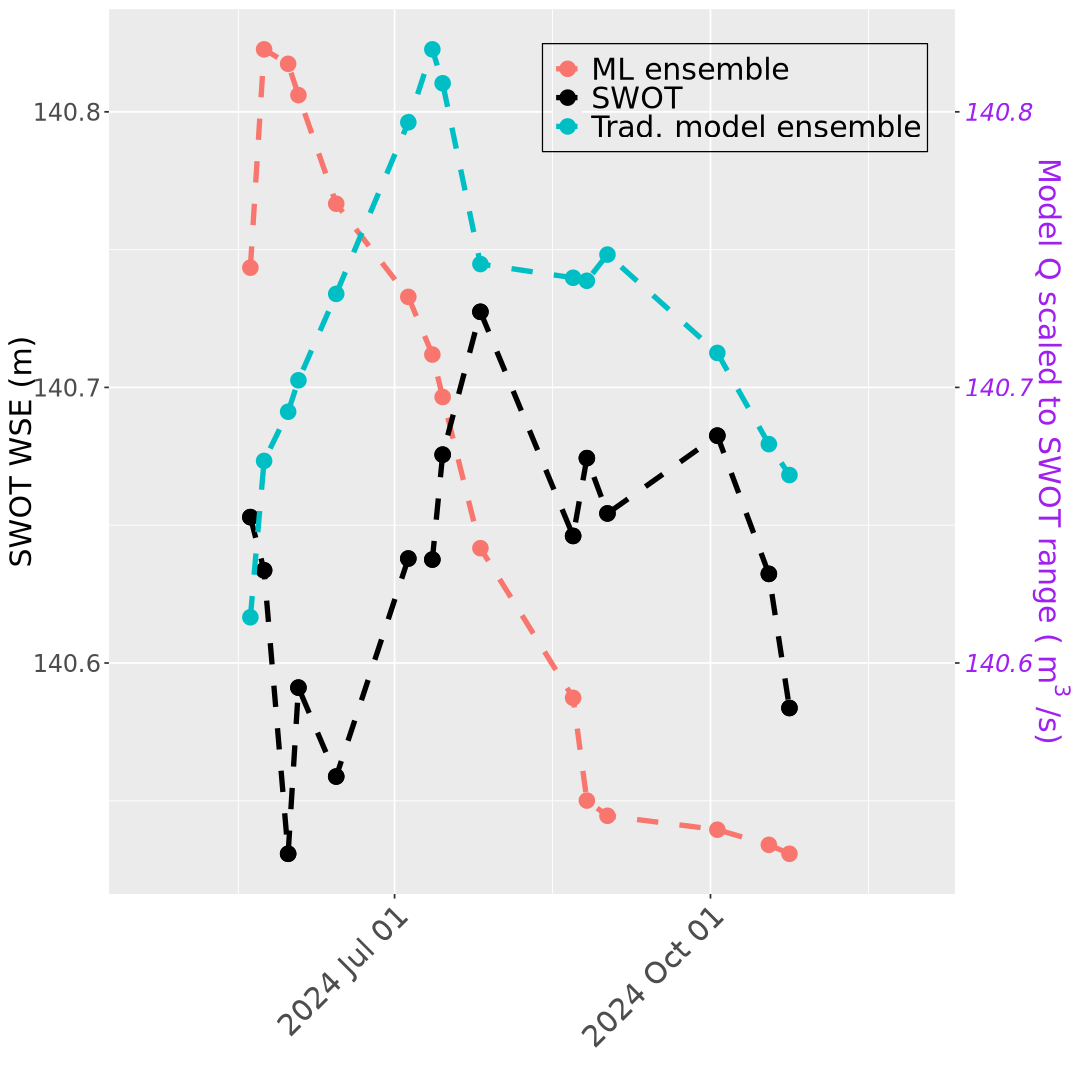

In [30]:

p2=ggplot(plotter,aes(x=date,y=height,col=model))+

 geom_point(size=4)+
scale_color_manual(values=c('#F8766D','black','#00BFC4'))+

geom_line(linetype='dashed',lwd=1.5)+

    scale_y_continuous(sec.axis = sec_axis(~., name = expression("Model Q scaled to SWOT range ("~m^3~"/s)")))+

    theme(axis.text.x = element_text(size=18, angle = 45, hjust = 1))+
    theme(legend.title = element_blank())+
    theme(text = element_text(size=18))+
    theme(legend.text=element_text(size=18))+
    ylab('SWOT WSE (m)')+
    xlab('')+

         theme(legend.box.margin = margin(1, 20, 1, 1))+
theme(legend.position =  c(0.74, 0.9),
    legend.background = element_rect(fill='transparent'),
         legend.box.background = element_rect(fill='transparent'),


    axis.text.y.right =  element_text(color = 'purple',face = "italic"),
    axis.title.y.right = element_text(color='purple',face = "italic"))+
scale_x_date(date_labels = "%Y %b %d",
            limits=c(as.Date('2024-04-20'),as.Date('2024-11-30')))

options(repr.plot.width=9, repr.plot.height=9)
p2
